### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [48]:
import numpy as np
import itertools

import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import XGate
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import Aer, transpile, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
import matplotlib.pyplot as plt
from qiskit import BasicAer, execute
import scipy as sc
import pandas as pd
from QPCA.decomposition.Qpca import QPCA
from qiskit.circuit.library.data_preparation.state_preparation import *
from QPCA.preprocessingUtilities.preprocessing_matrix_utilities import generate_matrix


In [126]:
example_matrix=generate_matrix(matrix_dimension=4,replicate_paper=False,seed=198)

Matrix:



<IPython.core.display.Math object>

eigenvalue: 0.10294957866401931 - eigenvector: [ 0.052 -0.107 -0.466  0.877]
eigenvalue: 0.038592840378554684 - eigenvector: [-0.306 -0.529  0.717  0.334]
eigenvalue: 0.5527166628591414 - eigenvector: [ 0.821 -0.558 -0.006 -0.119]
eigenvalue: 4.4240492887098934 - eigenvector: [0.479 0.63  0.519 0.324]


In [127]:
example_matrix1=example_matrix/np.trace(example_matrix)
example_matrix1,np.linalg.eig(example_matrix1)

(array([[0.27151278, 0.2122388 , 0.21189876, 0.12357353],
        [0.2122388 , 0.37911665, 0.28096841, 0.18041444],
        [0.21189876, 0.28096841, 0.2407929 , 0.1389232 ],
        [0.12357353, 0.18041444, 0.1389232 , 0.10857768]]),
 (array([0.86435771, 0.10798815, 0.00754016, 0.02011399]),
  array([[ 0.47850329,  0.82131265, -0.30630626,  0.05154225],
         [ 0.63009334, -0.55787199, -0.52949546, -0.10675105],
         [ 0.51869617, -0.00557219,  0.71699488, -0.46566251],
         [ 0.3239927 , -0.11913574,  0.33425944,  0.87698691]])))

In [128]:
sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

In [129]:
print(input_probabilities)

[0.0970964  0.0593297  0.05913974 0.02011284 0.0593297  0.1893077
 0.10397706 0.04287115 0.05913974 0.10397706 0.07636774 0.0254198
 0.02011284 0.04287115 0.0254198  0.01552758]


In [130]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    for k in range(1, int(np.ceil(np.log2(len(example_matrix)**2)))+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.ceil(np.log2(len(example_matrix)**2))))))][:len(input_probabilities)]
    
    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    
    #add root tree
    nodes.insert(0, 1)
    thetas=[]

    idx=0
    for i in range(1,len(nodes),2):
        
        right_node=i
        left_node=right_node+1
        if nodes[idx]!=0:
            thetas.append(2*np.arccos(nodes[right_node]/nodes[idx]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[idx]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx+=1
    return thetas, all_combinations

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
#thetas

In [131]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    #qc=QuantumCircuit(len(example_matrix))
    qc=QuantumCircuit(int(np.ceil(np.log2(len(example_matrix)**2))))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

0 -> 0.7944584860838365
1 -> 0.6073184616734276
00 -> 0.48546748151170144
01 -> 0.6288764668083131
10 -> 0.5146885854915031
11 -> 0.3223838920512844
000 -> 0.3955073856322908
001 -> 0.28151835378110707
010 -> 0.49863553356661433
011 -> 0.38320779633254487
100 -> 0.4038772129205728
101 -> 0.3190415912052136
110 -> 0.25096612434585663
111 -> 0.20235458552984223
0000 -> 0.3116029470098706
0001 -> 0.2435768780168868
0010 -> 0.24318663693011136
0011 -> 0.1418197557967392
0100 -> 0.2435768780168868
0101 -> 0.435095046892985
0110 -> 0.3224547452513483
0111 -> 0.20705350138293538
1000 -> 0.24318663693011136
1001 -> 0.3224547452513483
1010 -> 0.2763471286509517
1011 -> 0.1594358849353839
1100 -> 0.1418197557967392
1101 -> 0.20705350138293538
1110 -> 0.1594358849353839
1111 -> 0.12460969817724966


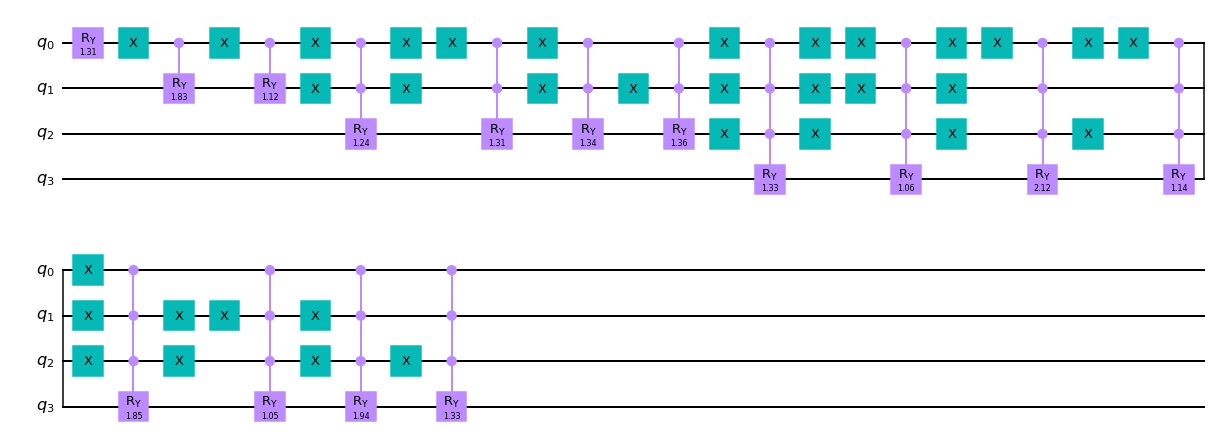

In [132]:
thetas, all_combinations = thetas_computation(example_matrix1)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw('mpl')

In [133]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


{'0000': 0.097096396585236,
 '0001': 0.059139740381378,
 '0010': 0.059329695504453,
 '0011': 0.020112843134247,
 '0100': 0.059139740381378,
 '0101': 0.076367735513626,
 '0110': 0.103977062735112,
 '0111': 0.025419801405129,
 '1000': 0.059329695504454,
 '1001': 0.103977062735112,
 '1010': 0.189307699830809,
 '1011': 0.042871152434933,
 '1100': 0.020112843134247,
 '1101': 0.025419801405129,
 '1110': 0.042871152434933,
 '1111': 0.015527576879825}

In [134]:
#Unitary for PE
resolution = 5
unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_22582/2943358390.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)


Operator([[ 0.7722236 +0.25579196j, -0.00168313-0.50754882j,
           -0.08336284-0.20313526j, -0.03155073-0.1772676j ],
          [-0.00168313-0.50754882j,  0.79499272-0.08881761j,
           -0.11234254-0.25578956j, -0.0835364 -0.13214345j],
          [-0.08336284-0.20313526j, -0.11234254-0.25578956j,
            0.90574843-0.15083343j, -0.05458644-0.16621351j],
          [-0.03155073-0.1772676j , -0.0835364 -0.13214345j,
           -0.05458644-0.16621351j,  0.95472622+0.03212092j]],
         input_dims=(2, 2), output_dims=(2, 2))

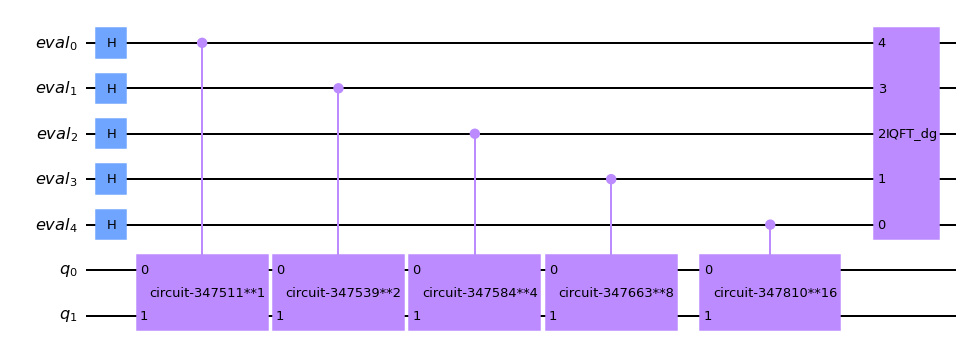

In [135]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

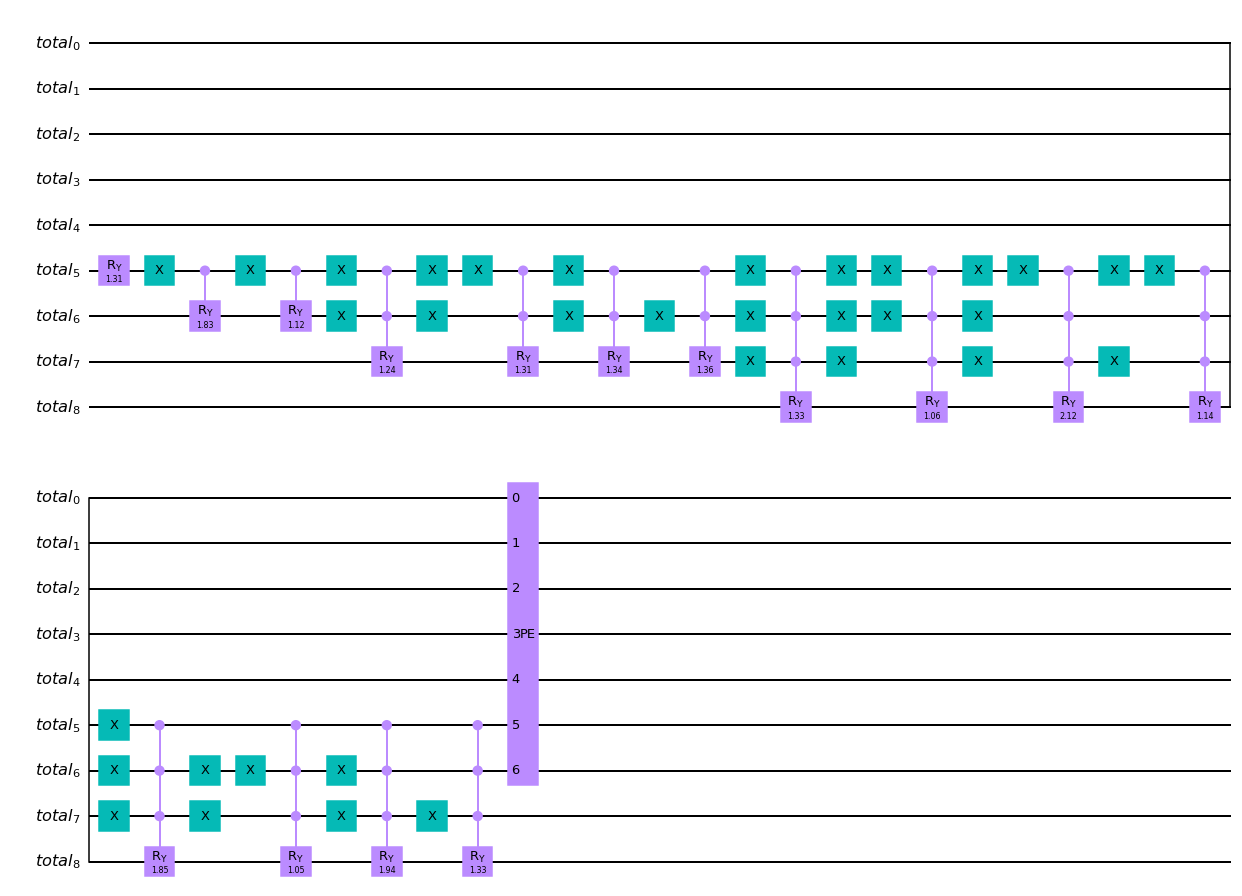

In [136]:
tot_qubit = resolution+len(example_matrix1)

qr_total_sim = QuantumRegister(tot_qubit, 'total')


total_circuit_sim = QuantumCircuit(qr_total_sim, name='matrix')

total_circuit_sim.append(matrix_circuit.to_gate(), qr_total_sim[resolution:])
total_circuit_sim.append(pe.to_gate(), qr_total_sim[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit_sim1.measure_all()

total_circuit_sim.decompose(reps=1).draw("mpl")

In [137]:
aer_back=Aer.get_backend('qasm_simulator')
st=aer_back.run(transpile(total_circuit_sim1,aer_back)).result().get_counts()
plot_histogram(st)

QiskitError: 'No counts for experiment "0"'

# Threshold example of paper

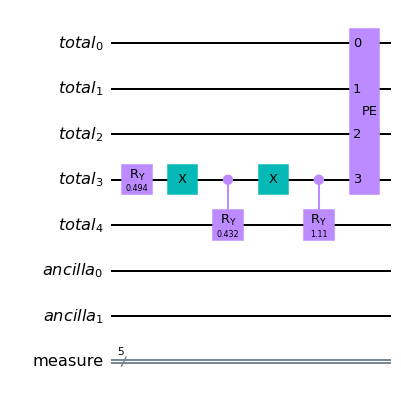

In [14]:
ancilla=2
ancilla_reg=QuantumRegister(ancilla,'ancilla')
tot_qubit = resolution+len(example_matrix1)

qr_total_sim = QuantumRegister(tot_qubit, 'total')
classical = ClassicalRegister(5, 'measure')

total_circuit_sim = QuantumCircuit(qr_total_sim,ancilla_reg,classical, name='matrix')
display(total_circuit_sim)
total_circuit_sim.append(matrix_circuit.to_gate(), qr_total_sim[resolution:])
total_circuit_sim.append(pe.to_gate(), qr_total_sim[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit_sim.decompose(reps=1).draw("mpl")

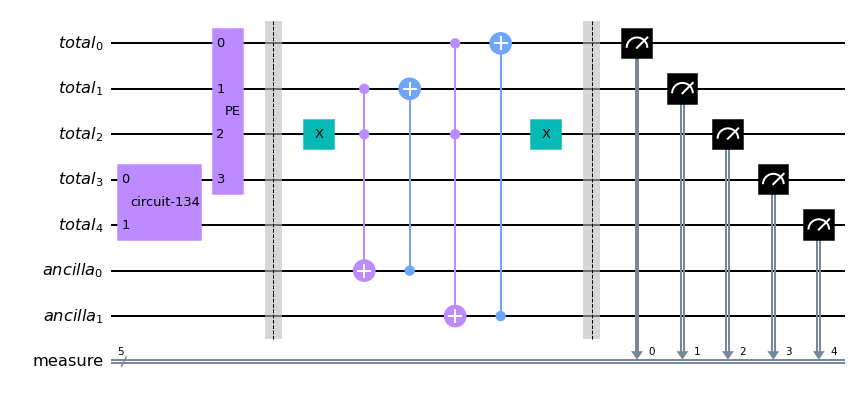

In [16]:
total_circuit_sim.barrier()
total_circuit_sim.x(2)
total_circuit_sim.ccx(1,2,ancilla_reg[0])
total_circuit_sim.cx(ancilla_reg[0],1)

total_circuit_sim.ccx(0,2,ancilla_reg[1])
total_circuit_sim.cx(ancilla_reg[1],0)
total_circuit_sim.x(2)
total_circuit_sim.barrier()
total_circuit_sim.measure([0,1,2,3,4],classical)
total_circuit_sim.draw('mpl')

In [17]:
#000,001,010,011
# Se togliamo il primo ccx/cx, tagliamo fuori 001 e 011 ma non 010.

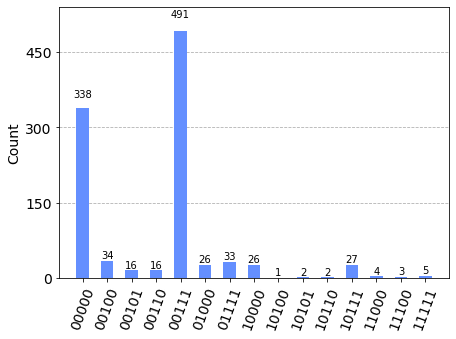

In [18]:
aer=Aer.get_backend('qasm_simulator')
result=aer.run(transpile(total_circuit_sim,aer)).result().get_counts()
plot_histogram(result)

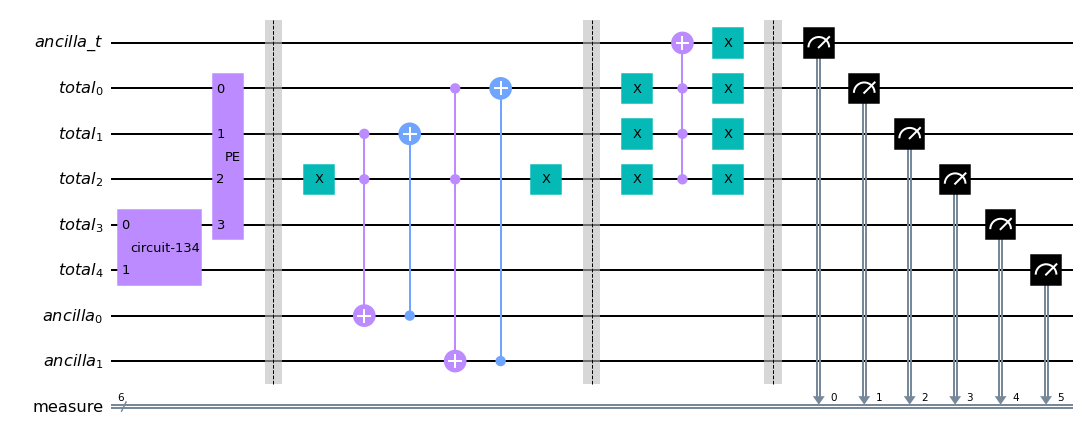

In [20]:
ancilla=2
ancilla_t=1
ancilla_reg_new=QuantumRegister(ancilla,'ancilla')
ancilla_reg_t_new=QuantumRegister(ancilla_t,'ancilla_t')
tot_qubit = resolution+len(example_matrix1)

qr_total_sim_new = QuantumRegister(tot_qubit, 'total')
classical = ClassicalRegister(6, 'measure')

total_circuit_sim_new = QuantumCircuit(ancilla_reg_t_new,qr_total_sim_new,ancilla_reg_new,classical, name='matrix')

total_circuit_sim_new.append(matrix_circuit.to_gate(), qr_total_sim_new[resolution:])
total_circuit_sim_new.append(pe.to_gate(), qr_total_sim_new[0:pe.num_qubits])
total_circuit_sim_new.decompose(reps=1).draw("mpl")
total_circuit_sim_new.barrier()
total_circuit_sim_new.x(3)
total_circuit_sim_new.ccx(2,3,ancilla_reg_new[0])
total_circuit_sim_new.cx(ancilla_reg_new[0],2)

total_circuit_sim_new.ccx(1,3,ancilla_reg_new[1])
total_circuit_sim_new.cx(ancilla_reg_new[1],1)
total_circuit_sim_new.x(3)
total_circuit_sim_new.barrier()
for i in range(3):
    total_circuit_sim_new.x(i+1)
total_circuit_sim_new.mcx(control_qubits=[1,2,3],target_qubit=ancilla_reg_t_new)
for i in range(3):
    total_circuit_sim_new.x(i+1)
total_circuit_sim_new.x(ancilla_reg_t_new)
total_circuit_sim_new.barrier()
total_circuit_sim_new.measure([0,1,2,3,4,5],classical)
total_circuit_sim_new.draw('mpl')

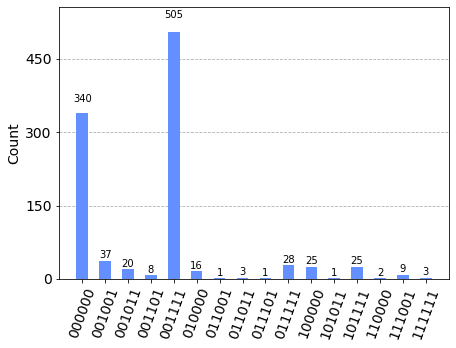

In [21]:
aer=Aer.get_backend('qasm_simulator')
result=aer.run(transpile(total_circuit_sim_new,aer)).result().get_counts()
plot_histogram(result)

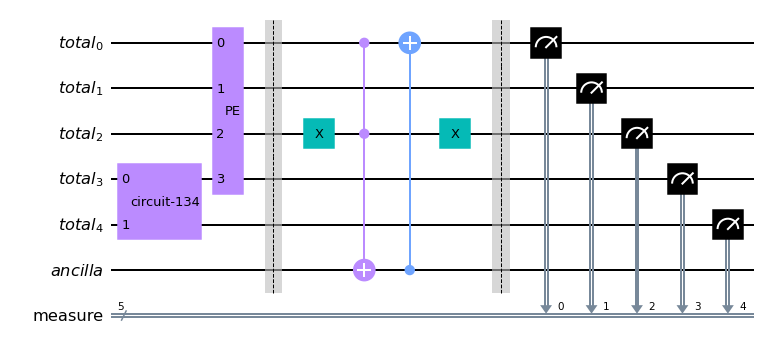

In [32]:
#Remove first cx
ancilla=1
ancilla_reg=QuantumRegister(ancilla,'ancilla')
tot_qubit = resolution+len(example_matrix1)

qr_total_sim = QuantumRegister(tot_qubit, 'total')
classical = ClassicalRegister(5, 'measure')

total_circuit_sim2 = QuantumCircuit(qr_total_sim,ancilla_reg,classical, name='matrix')
display(total_circuit_sim)
total_circuit_sim2.append(matrix_circuit.to_gate(), qr_total_sim[resolution:])
total_circuit_sim2.append(pe.to_gate(), qr_total_sim[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit_sim2.decompose(reps=1).draw("mpl")
total_circuit_sim2.barrier()
total_circuit_sim2.x(2)
#total_circuit_sim2.ccx(1,2,ancilla_reg[0])
#§total_circuit_sim2.cx(ancilla_reg[0],1)

total_circuit_sim2.ccx(0,2,ancilla_reg)
total_circuit_sim2.cx(ancilla_reg,0)
total_circuit_sim2.x(2)
total_circuit_sim2.barrier()
total_circuit_sim2.measure([0,1,2,3,4],classical)
total_circuit_sim2.draw('mpl')

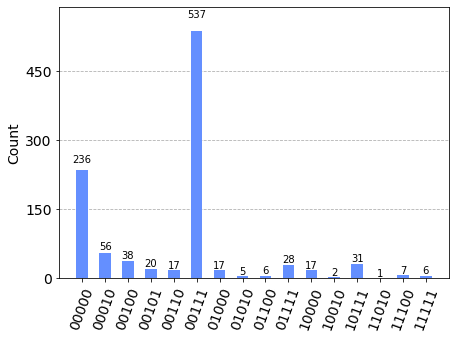

In [33]:
aer=Aer.get_backend('qasm_simulator')
result=aer.run(transpile(total_circuit_sim2,aer)).result().get_counts()
plot_histogram(result)

In [ ]:
#001,010,011-> taglia 011 ma non 010

In [138]:
# Create the first operator for tomography
op_U=total_circuit_sim.to_gate(label='op_U').control()

In [139]:
backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit_sim, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [140]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

In [141]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
sim_statevector=attach_bitstrings(statevector)


In [142]:
int(np.log2(len(sim_statevector))-4)

5

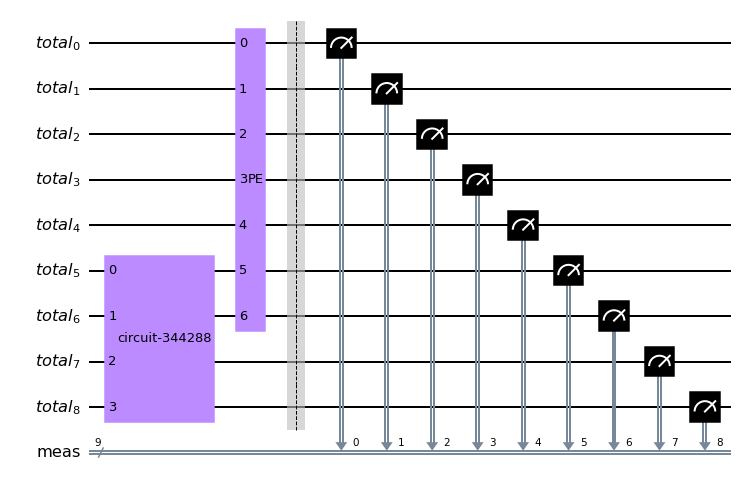

In [143]:
tot_qubit = resolution+len(example_matrix1)
#print(tot_qubit)
qr_total = QuantumRegister(tot_qubit, 'total')

total_circuit = QuantumCircuit(qr_total, name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
#total_circuit.barrier()
total_circuit.measure_all()
total_circuit.draw("mpl")

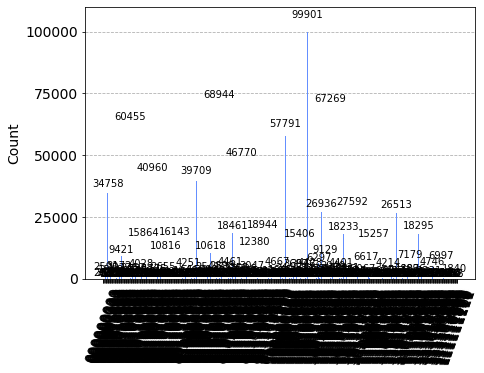

In [144]:
n_shots=1000000
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

In [145]:
for i in counts:
    counts[i]/=n_shots
#counts

In [146]:
statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
#statevector

In [147]:
#Create second operator tomography
op_V = StatePreparation(np.sqrt(statevector),label='c_V').control()

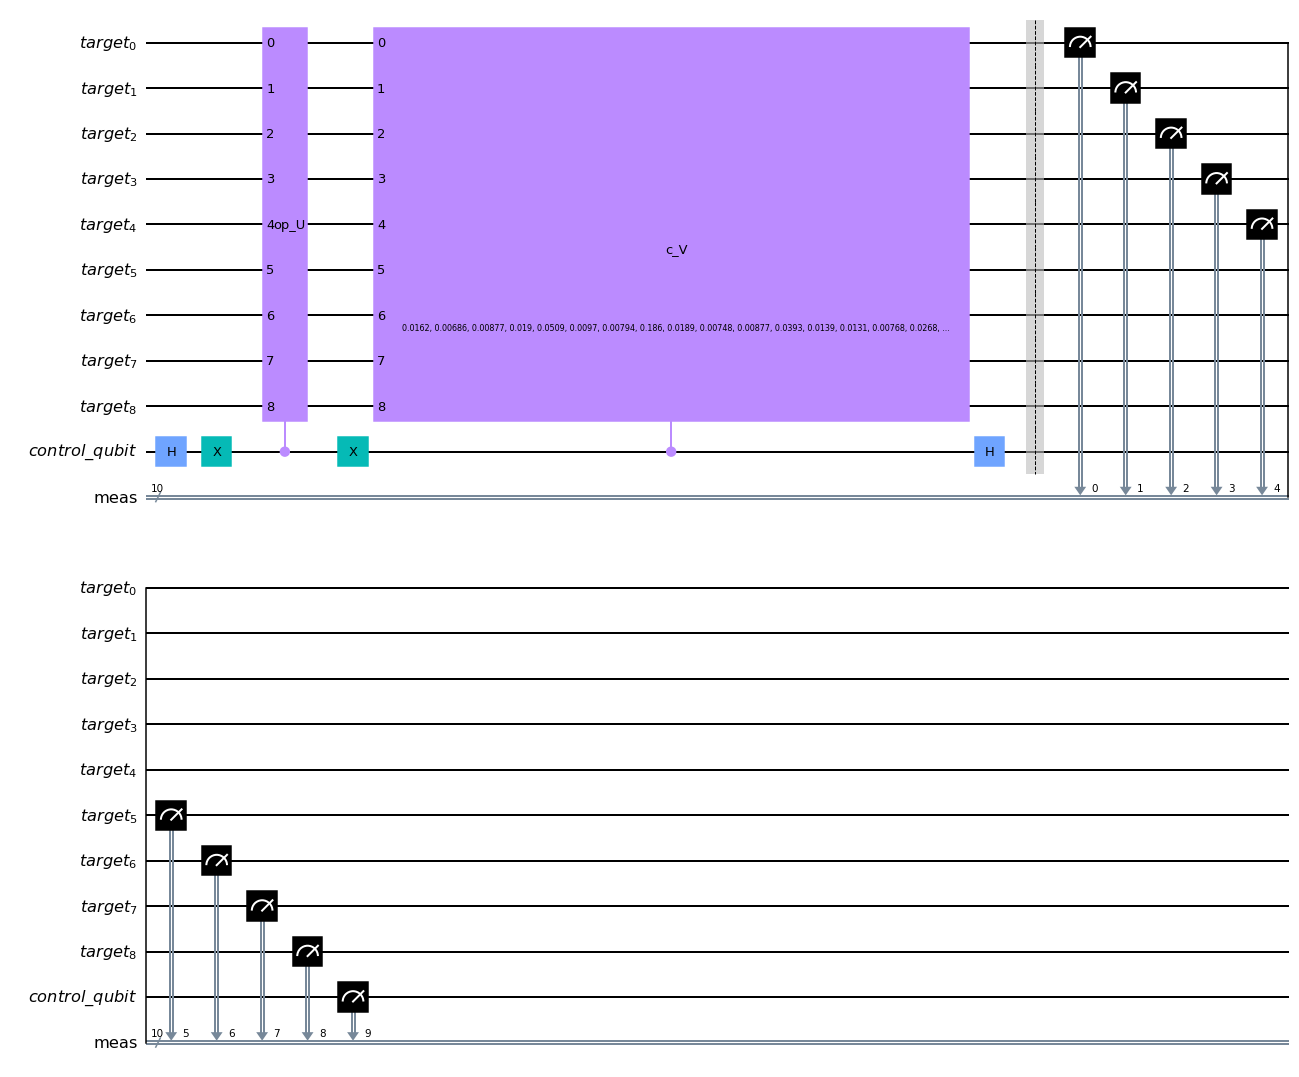

In [148]:

tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'target')
qr_control = QuantumRegister(1, 'control_qubit')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_control, name='matrix')
total_circuit_2.h(qr_control)
total_circuit_2.x(qr_control)

total_circuit_2.append(op_U, qr_control[:]+qr_total_xi[:])
total_circuit_2.x(qr_control)
total_circuit_2.append(op_V, qr_control[:]+qr_total_xi[:])
total_circuit_2.h(qr_control)
total_circuit_2.measure_all()
total_circuit_2.draw("mpl")

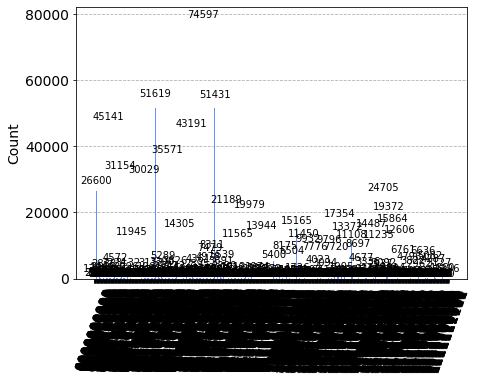

In [149]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_2, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [150]:
#Take only counts with control qubits equal to 0
tmp=np.zeros(2**tot_qubit)
for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
#tmp

In [151]:
###Metodo Nannicini

'''tmp_=tmp/(sum(tmp))

sign_diff=[]
sign=[]
x_list=[]
for i in range(len(tmp_)):
    x=(np.sqrt(statevector[i])*0.5)+(((statevector[i])/np.sqrt(statevector[i]))*0.5) - (tmp_[i]/(2*np.sqrt(statevector[i])))
    
    x_list.append(x)
    
    sign_diff.append(np.sign(x)+np.sign((sim_statevector[i][1].real)))
    sign.append(np.sign(x))
    '''

'tmp_=tmp/(sum(tmp))\n\nsign_diff=[]\nsign=[]\nx_list=[]\nfor i in range(len(tmp_)):\n    x=(np.sqrt(statevector[i])*0.5)+(((statevector[i])/np.sqrt(statevector[i]))*0.5) - (tmp_[i]/(2*np.sqrt(statevector[i])))\n    \n    x_list.append(x)\n    \n    sign_diff.append(np.sign(x)+np.sign((sim_statevector[i][1].real)))\n    sign.append(np.sign(x))\n    '

In [152]:
#Sign estimation
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=1
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

In [153]:
statevector_dictionary={}
for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

#statevector_dictionary

In [154]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
ss=attach_bitstrings(statevector)
#ss

In [155]:
df=pd.DataFrame(ss)

df.columns=['state','module']
df

,state,module
0,000000000,0.000263
1,000000001,0.000047
2,000000010,0.000077
3,000000011,0.000362
4,000000100,0.002590
...,...,...
507,111111011,0.001840
508,111111100,0.000003
509,111111101,0.000052
510,111111110,0.000011


In [156]:
df['lambda']=df['state'].apply(lambda x: x[-resolution:])
df1=df.groupby('lambda').agg({'module':'sum'})
#df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df1=df1.sort_values('module',ascending=False)
df1

,module
lambda,
00111,0.646298
11011,0.171649
10111,0.042259
01011,0.027520
00000,0.026344
01111,0.014167
10011,0.010748
11111,0.007793
11000,0.007093


In [157]:
tail=df1.reset_index()
tail

,lambda,module
0,00111,0.646298
1,11011,0.171649
2,10111,0.042259
3,01011,0.027520
4,00000,0.026344
5,01111,0.014167
6,10011,0.010748
7,11111,0.007793
8,11000,0.007093
9,10000,0.006875


In [158]:
tail['num']=tail['lambda'].apply(lambda x :int(x[::-1],base=2)/(2**resolution))

In [159]:
tail.head(20)

,lambda,module,num
0,00111,0.646298,0.87500
1,11011,0.171649,0.84375
2,10111,0.042259,0.90625
3,01011,0.027520,0.81250
4,00000,0.026344,0.00000
5,01111,0.014167,0.93750
6,10011,0.010748,0.78125
7,11111,0.007793,0.96875
8,11000,0.007093,0.09375
9,10000,0.006875,0.03125


In [160]:
'''tail1['num']+=0.1
tail1'''

"tail1['num']+=0.1\ntail1"

In [161]:
np.linalg.eig(example_matrix1)

(array([0.86435771, 0.10798815, 0.00754016, 0.02011399]),
 array([[ 0.47850329,  0.82131265, -0.30630626,  0.05154225],
        [ 0.63009334, -0.55787199, -0.52949546, -0.10675105],
        [ 0.51869617, -0.00557219,  0.71699488, -0.46566251],
        [ 0.3239927 , -0.11913574,  0.33425944,  0.87698691]]))

In [192]:
offset

1e-06

In [199]:
from scipy.signal import find_peaks

peaks=[]
nums_peaks=[]
offset=1/n_shots
stop=False
while stop==False:
    print('|')
    right_thresholds=find_peaks(tail.sort_values(['num'])['module'],threshold=offset)[1]['right_thresholds']
    left_thresholds=find_peaks(tail.sort_values(['num'])['module'],threshold=offset)[1]['left_thresholds']
    mean=(right_thresholds+left_thresholds)/2
    p=find_peaks(tail.sort_values(['num'])['module'],threshold=offset,height=0.001)[0]
    
    if len(p)>len(example_matrix1):
        offset+=1/n_shots
    else:
        stop=True
        for i in p:
            el = tail.sort_values(['num']).iloc[i]
            nums_peaks.append(el['num'])
            peaks.append(el['lambda'])
        print(nums_peaks)

sorted_peaks=np.array(peaks)[mean.argsort()[::-1]]
sorted_num_peaks=np.array(nums_peaks)[mean.argsort()[::-1]]
peaks,np.array(nums_peaks)

|
[0.09375, 0.875]


IndexError: index 3 is out of bounds for axis 0 with size 2

In [179]:
sorted_num_peaks

array([0.875  , 0.09375, 0.3125 , 0.375  ])

In [180]:
min_=10000
values_not_to_keep=[]
for k in np.array(nums_peaks)[~np.argwhere(mean == np.amin(mean))]:
    a=find_nearest(np.linalg.eig(example_matrix1)[0],k[0])
    gg=abs(a-k[0])
    if gg<min_:
        min_=gg
        value_to_keep=k[0]
    

print(value_to_keep)


NameError: name 'find_nearest' is not defined

In [148]:
idx=[list(sorted_num_peaks).index(x) for x in values_not_to_keep if x in sorted_num_peaks]
idx

[2]

In [157]:
values_not_to_keep=[v for v in np.array(nums_peaks)[np.argwhere(mean == np.amin(mean))] if v!=value_to_keep]
values_not_to_keep

[array([0.84765625])]

In [143]:
new_peaks=[v for v in sorted_num_peaks if v not in values_not_to_keep]
new_peaks

[0.84765625, 0.09375]

In [104]:
right_thresholds,left_thresholds

(array([0.01, 0.01, 0.95]), array([0.01, 0.01, 0.95]))

In [64]:
(right_thresholds+left_thresholds)/2

array([0.004, 0.002, 0.98 ])

In [41]:
sorted_peaks,sorted_num_peaks,right_thresholds

(array(['00110111', '10000000', '11001000', '01111011'], dtype='<U8'),
 array([0.921875  , 0.00390625, 0.07421875, 0.8671875 ]),
 array([2.51622e-01, 1.19016e-01, 2.20000e-05, 3.71010e-01]))

In [303]:
check_eigenvalues={}
for i in np.linalg.eig(example_matrix1)[0]:
    check_eigenvalues.update({i:0})
check_eigenvalues

{0.8955238958986377: 0,
 0.00030420453127693393: 0,
 0.05567682172622658: 0,
 0.04849507784385881: 0}

In [125]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [305]:
for s_p in sorted_num_peaks:
    x=find_nearest(np.linalg.eig(example_matrix1)[0],s_p)
    print(x)
    if check_eigenvalues[x]==0:
        check_eigenvalues.update({x:1})
    else:
        continue
print(check_eigenvalues)

0.8955238958986377
0.05567682172622658
0.04849507784385881
{0.8955238958986377: 1, 0.00030420453127693393: 0, 0.05567682172622658: 1, 0.04849507784385881: 1}


In [306]:
new_original_eigenvalues=[]
for d in list(check_eigenvalues.keys()):
    if check_eigenvalues[d]==1:
        check_eigenvalues.pop(d)
        new_original_eigenvalues.append(d)
        #new_original_eigenvalues.append(d)
        #del check_eigenvalues[d]
check_eigenvalues

{0.00030420453127693393: 0}

In [307]:
if len(check_eigenvalues)>0:
    new_original_eigenvalues.append(list(check_eigenvalues.keys())[0])
else:
    new_original_eigenvalues=sorted(new_original_eigenvalues,reverse=True)
new_original_eigenvalues

[0.8955238958986377,
 0.05567682172622658,
 0.04849507784385881,
 0.00030420453127693393]

In [317]:
np.linalg.eig(example_matrix1),np.linalg.eig(example_matrix1)[1][:,1]

((array([8.95523896e-01, 3.04204531e-04, 5.56768217e-02, 4.84950778e-02]),
  array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
         [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
         [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
         [-0.54730826,  0.17339042,  0.45175377,  0.68286746]])),
 array([-0.31079311, -0.72369209,  0.59128095,  0.17339042]))

In [334]:
new_idx=[]
for i in new_original_eigenvalues:
    for j in range(len(np.linalg.eig(example_matrix1)[0])):
        if i==np.linalg.eig(example_matrix1)[0][j]:
            new_idx.append(np.linalg.eig(example_matrix1)[1][:,j])
            
new_idx=np.array(new_idx)

In [336]:
new_idx.reshape(4,4).T

array([[-0.54010974, -0.76691778,  0.15338266, -0.31079311],
       [-0.34101425,  0.45528741, -0.39075876, -0.72369209],
       [-0.54078131,  0.021657  , -0.59789078,  0.59128095],
       [-0.54730826,  0.45175377,  0.68286746,  0.17339042]])

In [181]:
peaks=[]
nums_peaks=[]
peaks.append(tail.iloc[0]['lambda'])
nums_peaks.append(tail.iloc[0]['num'])
for i in range(1,len(tail)):
    
    #for n_ in nums_peaks:
        
    if any(abs(tail.iloc[i]['num']-n_)<= 4/(2**resolution) for n_ in nums_peaks):
        #if any(abs(tail1.iloc[i]['num']-n_)/n_<= 0.2 for n_ in nums_peaks):
        pass
    else:
           
        nums_peaks.append(tail.iloc[i]['num'])
        peaks.append(tail.iloc[i]['lambda'])
        pass
    if len(peaks)==len(example_matrix1):
        break
    #print(tail.iloc[i])

In [182]:
peaks,np.array(nums_peaks)

(['00111', '00000', '11101', '10100'],
 array([0.875  , 0.     , 0.71875, 0.15625]))

In [183]:
np.linalg.eig(example_matrix1)

(array([0.86435771, 0.10798815, 0.00754016, 0.02011399]),
 array([[ 0.47850329,  0.82131265, -0.30630626,  0.05154225],
        [ 0.63009334, -0.55787199, -0.52949546, -0.10675105],
        [ 0.51869617, -0.00557219,  0.71699488, -0.46566251],
        [ 0.3239927 , -0.11913574,  0.33425944,  0.87698691]]))

<AxesSubplot: xlabel='num'>

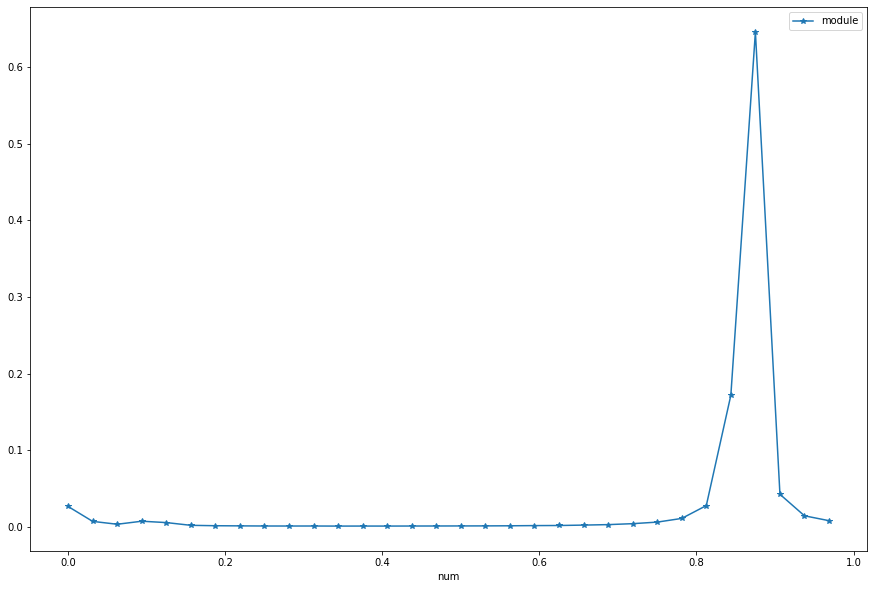

In [184]:
tail[['num','module']].sort_values('num').set_index('num').plot(style='-*',figsize=(15,10))

In [149]:
'''lambdas=df1.tail(len(example_matrix1)).index.values
lambdas'''

'lambdas=df1.tail(len(example_matrix1)).index.values\nlambdas'

In [43]:
lambdas=peaks
lambdas

['10000000', '11001000', '01111011', '00110111']

In [44]:
df.columns=['state','module','lambda']
df

,state,module,lambda
0,000000000000,0.011017,00000000
1,000000000001,0.000002,00000001
2,000000000010,0.000002,00000010
3,000000000011,0.000003,00000011
4,000000000100,0.000042,00000100
...,...,...,...
4091,111111111011,0.000000,11111011
4092,111111111100,0.000000,11111100
4093,111111111101,0.000000,11111101
4094,111111111110,0.000000,11111110


In [45]:
df['sign']=np.array(list(sign_dictionary.values()))
#df['sign']=np.array(sign)
df

,state,module,lambda,sign
0,000000000000,0.011017,00000000,1
1,000000000001,0.000002,00000001,1
2,000000000010,0.000002,00000010,1
3,000000000011,0.000003,00000011,-1
4,000000000100,0.000042,00000100,-1
...,...,...,...,...
4091,111111111011,0.000000,11111011,1
4092,111111111100,0.000000,11111100,1
4093,111111111101,0.000000,11111101,1
4094,111111111110,0.000000,11111110,1


In [46]:
df['module']=df['module'].multiply(np.array(list(sign_dictionary.values())), axis=0)
#df['module']=df['module'].multiply(np.array(sign), axis=0)
df=df.fillna(0)
df

,state,module,lambda,sign
0,000000000000,0.011017,00000000,1
1,000000000001,0.000002,00000001,1
2,000000000010,0.000002,00000010,1
3,000000000011,-0.000003,00000011,-1
4,000000000100,-0.000042,00000100,-1
...,...,...,...,...
4091,111111111011,0.000000,11111011,1
4092,111111111100,0.000000,11111100,1
4093,111111111101,0.000000,11111101,1
4094,111111111110,0.000000,11111110,1


In [47]:
#df['st']=sim_statevector

In [155]:
df.query("state.str.endswith('01111000')")

,state,module,lambda,sign


In [48]:
a=[]
save_sign=[]
eigenvalues=[]
for l in lambdas:
    eigenvalues.append(int(l[::-1],base=2)/(2**resolution))
    a_=np.array(df.query("state.str.endswith(@l)")['module'].values)
    #print(a_)
    save_sign.append(np.sign(a_))
    #print(save_sign)
    
    a.append(np.sqrt(abs(a_)))

#a=[a1,a2]

for i in range(len(a)):
    print(a[i])
    normalization_factor=np.sqrt((1/(sum(a[i]**2))))
    print(normalization_factor)
    a[i]*=normalization_factor
    a[i]*=save_sign[i]
    
    print(a)

[0.18328939 0.47194385 0.01954482 0.         0.03903844 0.10300485
 0.00608276 0.         0.01224745 0.03310589 0.00173205 0.
 0.01236932 0.03313608 0.00173205 0.        ]
1.9195944279350001
[array([-0.35184129,  0.90594079, -0.03751813,  0.        ,  0.07493798,
       -0.19772754, -0.01167644,  0.        ,  0.02351013, -0.06354988,
        0.00332484,  0.        ,  0.02374407, -0.06360784, -0.00332484,
        0.        ]), array([0.29666311, 0.10487135, 0.17418668, 0.        , 0.08590693,
       0.03170173, 0.05180734, 0.        , 0.00574456, 0.00223607,
       0.00360555, 0.        , 0.00648074, 0.00282843, 0.00360555,
       0.        ]), array([0.00316228, 0.00565685, 0.001     , 0.        , 0.00244949,
       0.00141421, 0.00223607, 0.        , 0.001     , 0.001     ,
       0.001     , 0.        , 0.001     , 0.001     , 0.002     ,
       0.        ]), array([0.13796376, 0.06463745, 0.26967759, 0.        , 0.19898241,
       0.0931182 , 0.3959457 , 0.        , 0.08383913, 0.03

In [49]:
eigenvalues

[0.00390625, 0.07421875, 0.8671875, 0.921875]

In [50]:
#TODO: Capire se fare la media tra i vari fattori di rescaling
eigenvectors=[]
for ll, eig in zip(a,eigenvalues):
    
    eigenvector=np.zeros(len(example_matrix1)) #put length of eigenvector
    save_sign=np.sign(ll)
    sv=abs(ll)
    max_list=[]
    scaled_statevectors=[]
    for e,i in enumerate(range(0,len(sv),len(example_matrix1))):
        max_list.append(max(sv[i:i+len(example_matrix1)]))
        scaled_statevectors.append(sv[i:i+len(example_matrix1)]/max_list[e])
        #print(max_list,scaled_statevectors)
    idx_max=np.argmax(max_list)
    #print(idx_max)
    max_max=max_list[idx_max]
    #print(max_max)
    value=np.sqrt(max_max)
    #eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
    eigenvector=scaled_statevectors[idx_max]*value*save_sign[len(example_matrix1)*idx_max:len(example_matrix1)*idx_max+len(example_matrix1)]
    eigenvectors.append((eig,eigenvector))
    print('reconstructed_eigenvector:',eigenvector)
    print('reconstructed_eigenvalue:', eig)
    

reconstructed_eigenvector: [-0.36965527  0.95180922 -0.0394177   0.        ]
reconstructed_eigenvalue: 0.00390625
reconstructed_eigenvector: [ 0.88958763  0.31447205 -0.52232419  0.        ]
reconstructed_eigenvalue: 0.07421875
reconstructed_eigenvector: [ 0.46825688  0.83764337 -0.14807583  0.        ]
reconstructed_eigenvalue: 0.8671875
reconstructed_eigenvector: [0.40421423 0.18916096 0.8043268  0.        ]
reconstructed_eigenvalue: 0.921875


In [51]:
np.array(eigenvalues)*np.trace(example_matrix)

array([0.01114745, 0.21180152, 2.47473358, 2.63079786])

In [52]:
np.linalg.eig(example_matrix1)#,np.linalg.eig(example_matrix2)

(array([0.92221665, 0.07531465, 0.0024687 , 0.        ]),
 array([[-0.43714001, -0.82468914,  0.35888219,  0.        ],
        [-0.2051187 , -0.29709624, -0.93255571,  0.        ],
        [-0.87569112,  0.48127086,  0.03928651,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

NameError: name 'eig' is not defined